In [ ]:
!pip install datasets sentence-transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
from datasets import load_dataset
from itertools import islice
import random

# Küçük subset almak için streaming=True ve take kullanacağız
dataset = load_dataset(
    "wikimedia/wikipedia",
    "20231101.en",      # Dump tarihi (Kasım 2023 İngilizce)
    split="train",
    streaming=True,
)

# Karıştırma işlemi ekleyelim (streaming dataset için shuffle metodu)
#dataset = dataset.shuffle(seed=42) # to make it reproducible

# İlk 1000 makaleyi listeye çekelim
dataset_small = list(islice(dataset, 1000))


print(len(dataset_small))
print(dataset_small[0].keys())
print(dataset_small[0]["text"][:500])

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

1000
dict_keys(['id', 'url', 'title', 'text'])
Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy, typically including nation-states, and capitalism. Anarchism advocates for the replacement of the state with stateless societies and voluntary free associations. As a historically left-wing movement, this reading of anarchism is placed on the farthest left of the political spectrum, usually described as


In [ ]:
import nltk, uuid

nltk.download("punkt")
nltk.download("punkt_tab")  # yeni eklenen paket
from nltk.tokenize import sent_tokenize

def chunk_text(text, max_tokens=250):
    sentences = sent_tokenize(text)
    chunks, current_chunk, current_tokens = [], [], 0

    for sent in sentences:
        tokens = sent.split()
        if current_tokens + len(tokens) > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk, current_tokens = [], 0
        current_chunk.append(sent)
        current_tokens += len(tokens)
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

chunked_data = []
for doc in dataset_small:
    for i, chunk in enumerate(chunk_text(doc['text'])):
        chunked_data.append({
            "chunk_id": str(uuid.uuid4()),
            "doc_id": doc['id'],
            "title": doc['title'],
            "text": chunk,
            "source": doc['url'],
            "chunk_idx": i
        })

print(f"Toplam chunk sayısı: {len(chunked_data)}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Toplam chunk sayısı: 15502


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

# 1. Başlık listesi
titles = sorted(set([c["title"] for c in chunked_data]))
print(f"Toplam {len(titles)} benzersiz başlık var.")

# 2. Embedding
model = SentenceTransformer("all-MiniLM-L6-v2")
title_embeddings = model.encode(titles, normalize_embeddings=True, show_progress_bar=True)

Toplam 1000 benzersiz başlık var.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


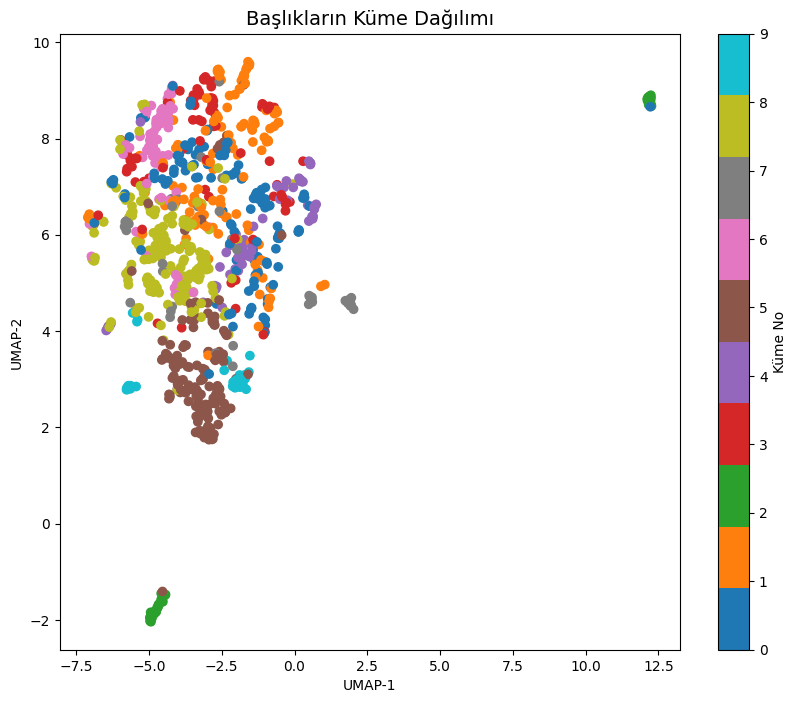


Küme 0 (128 başlık):
 - A Fire Upon the Deep  |  https://en.wikipedia.org/wiki/A%20Fire%20Upon%20the%20Deep
 - A Modest Proposal  |  https://en.wikipedia.org/wiki/A%20Modest%20Proposal
 - AFC Ajax  |  https://en.wikipedia.org/wiki/AFC%20Ajax
 - AS Roma  |  https://en.wikipedia.org/wiki/AS%20Roma
 - Aachen  |  https://en.wikipedia.org/wiki/Aachen
 - Abbey  |  https://en.wikipedia.org/wiki/Abbey
 - Abbotsford, Scottish Borders  |  https://en.wikipedia.org/wiki/Abbotsford%2C%20Scottish%20Borders
 - Aberdeen  |  https://en.wikipedia.org/wiki/Aberdeen
 - Aberdeen (disambiguation)  |  https://en.wikipedia.org/wiki/Aberdeen%20%28disambiguation%29
 - Aberdeenshire  |  https://en.wikipedia.org/wiki/Aberdeenshire

Küme 1 (146 başlık):
 - A  |  https://en.wikipedia.org/wiki/A
 - A Clockwork Orange (novel)  |  https://en.wikipedia.org/wiki/A%20Clockwork%20Orange%20%28novel%29
 - A cappella  |  https://en.wikipedia.org/wiki/A%20cappella
 - A360media  |  https://en.wikipedia.org/wiki/A360media
 - A

In [ ]:




# 3. Boyut indirgeme (UMAP daha net kümeler çıkarır)
reducer = umap.UMAP(random_state=42, n_neighbors=10, min_dist=0.1)
embedding_2d = reducer.fit_transform(title_embeddings)

# 4. K-Means kümeleme
n_clusters = 10  # isteğe göre değiştirilebilir
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(title_embeddings)

title2url = {}
for c in chunked_data:
    if c["title"] not in title2url:
        title2url[c["title"]] = c.get("source", "")

# (İsteğe bağlı) 20 küme için daha uygun renk paleti
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap="tab10")
plt.title("Başlıkların Küme Dağılımı", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Küme No")
plt.show()

# Küme içeriklerini URL ile yazdır
from collections import defaultdict
clusters = defaultdict(list)
for title, label in zip(titles, cluster_labels):
    clusters[label].append(title)

for label in sorted(clusters.keys()):
    print(f"\nKüme {label} ({len(clusters[label])} başlık):")
    for t in clusters[label][:10]:
        url = title2url.get(t, "")
        print(f" - {t}  |  {url}")

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


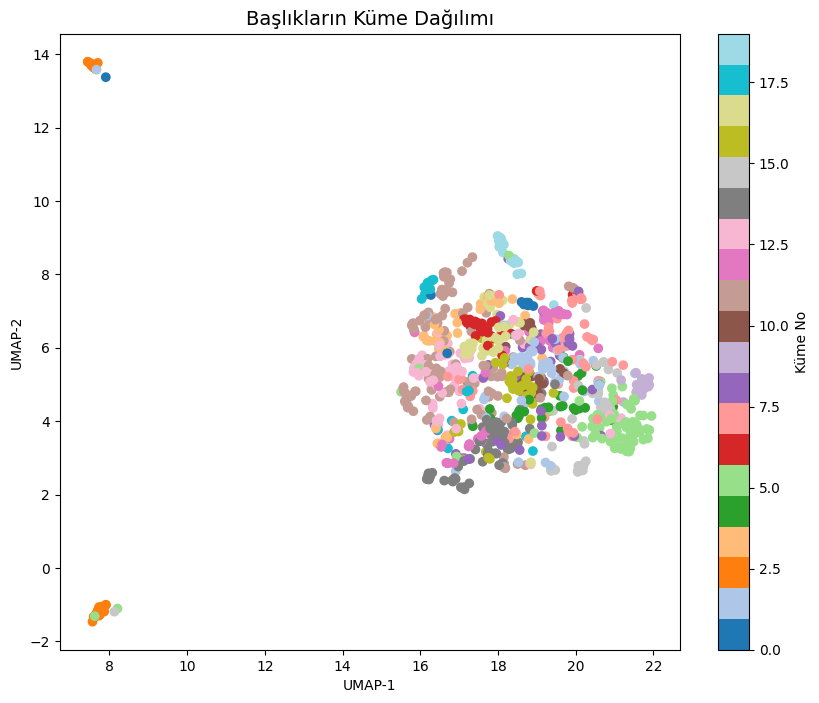


Küme 0 (11 başlık):
 - Alessandro Allori  |  https://en.wikipedia.org/wiki/Alessandro%20Allori
 - All Souls' Day  |  https://en.wikipedia.org/wiki/All%20Souls%27%20Day
 - Allegory  |  https://en.wikipedia.org/wiki/Allegory
 - Allele  |  https://en.wikipedia.org/wiki/Allele
 - Allocution  |  https://en.wikipedia.org/wiki/Allocution
 - Allomorph  |  https://en.wikipedia.org/wiki/Allomorph
 - Allophone  |  https://en.wikipedia.org/wiki/Allophone
 - Allosaurus  |  https://en.wikipedia.org/wiki/Allosaurus
 - Allotropy  |  https://en.wikipedia.org/wiki/Allotropy
 - Almost all  |  https://en.wikipedia.org/wiki/Almost%20all

Küme 1 (65 başlık):
 - ALF Tales  |  https://en.wikipedia.org/wiki/ALF%20Tales
 - AVL tree  |  https://en.wikipedia.org/wiki/AVL%20tree
 - Acapulco  |  https://en.wikipedia.org/wiki/Acapulco
 - Achaeans (Homer)  |  https://en.wikipedia.org/wiki/Achaeans%20%28Homer%29
 - Achilles  |  https://en.wikipedia.org/wiki/Achilles
 - Actaeon  |  https://en.wikipedia.org/wiki/Actaeo

In [ ]:

# 3. Boyut indirgeme (UMAP daha net kümeler çıkarır)
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1)
embedding_2d = reducer.fit_transform(title_embeddings)

# 4. K-Means kümeleme
n_clusters = 20  # isteğe göre değiştirilebilir
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(title_embeddings)
# --- Başlık -> URL haritası (ilk görülen URL'yi al)
title2url = {}
for c in chunked_data:
    if c["title"] not in title2url:
        title2url[c["title"]] = c.get("source", "")

# (İsteğe bağlı) 20 küme için daha uygun renk paleti
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap="tab20")
plt.title("Başlıkların Küme Dağılımı", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Küme No")
plt.show()

# Küme içeriklerini URL ile yazdır
from collections import defaultdict
clusters = defaultdict(list)
for title, label in zip(titles, cluster_labels):
    clusters[label].append(title)

for label in sorted(clusters.keys()):
    print(f"\nKüme {label} ({len(clusters[label])} başlık):")
    for t in clusters[label][:10]:
        url = title2url.get(t, "")
        print(f" - {t}  |  {url}")

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


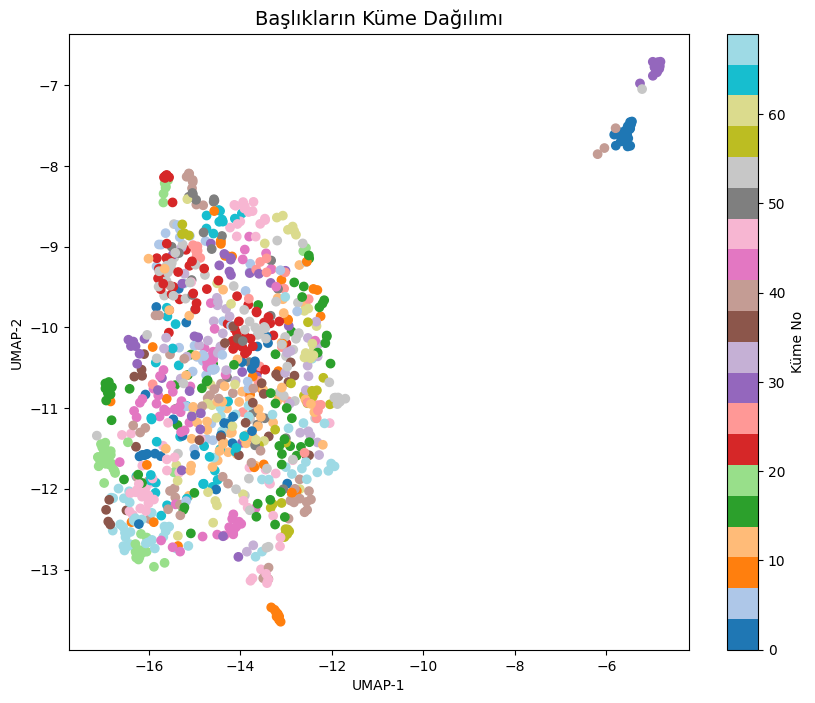


Küme 0 (8 başlık):
 - Allegory  |  https://en.wikipedia.org/wiki/Allegory
 - Allele  |  https://en.wikipedia.org/wiki/Allele
 - Allocution  |  https://en.wikipedia.org/wiki/Allocution
 - Allomorph  |  https://en.wikipedia.org/wiki/Allomorph
 - Allophone  |  https://en.wikipedia.org/wiki/Allophone
 - Allosaurus  |  https://en.wikipedia.org/wiki/Allosaurus
 - Allotropy  |  https://en.wikipedia.org/wiki/Allotropy
 - Almost all  |  https://en.wikipedia.org/wiki/Almost%20all

Küme 1 (14 başlık):
 - Aedile  |  https://en.wikipedia.org/wiki/Aedile
 - Aeneas  |  https://en.wikipedia.org/wiki/Aeneas
 - Aeolus  |  https://en.wikipedia.org/wiki/Aeolus
 - Aeon  |  https://en.wikipedia.org/wiki/Aeon
 - Aeschylus  |  https://en.wikipedia.org/wiki/Aeschylus
 - Agesilaus II  |  https://en.wikipedia.org/wiki/Agesilaus%20II
 - Alaric I  |  https://en.wikipedia.org/wiki/Alaric%20I
 - Alaric II  |  https://en.wikipedia.org/wiki/Alaric%20II
 - Alarums and Excursions  |  https://en.wikipedia.org/wiki/Alaru

In [ ]:

# 3. Boyut indirgeme (UMAP daha net kümeler çıkarır)
reducer = umap.UMAP(random_state=42, n_neighbors=70, min_dist=0.1)
embedding_2d = reducer.fit_transform(title_embeddings)

# 4. K-Means kümeleme
n_clusters = 70  # isteğe göre değiştirilebilir
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(title_embeddings)
# --- Başlık -> URL haritası (ilk görülen URL'yi al)
title2url = {}
for c in chunked_data:
    if c["title"] not in title2url:
        title2url[c["title"]] = c.get("source", "")

# (İsteğe bağlı) 20 küme için daha uygun renk paleti
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap="tab20")
plt.title("Başlıkların Küme Dağılımı", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Küme No")
plt.show()

# Küme içeriklerini URL ile yazdır
from collections import defaultdict
clusters = defaultdict(list)
for title, label in zip(titles, cluster_labels):
    clusters[label].append(title)

for label in sorted(clusters.keys()):
    print(f"\nKüme {label} ({len(clusters[label])} başlık):")
    for t in clusters[label][:10]:
        url = title2url.get(t, "")
        print(f" - {t}  |  {url}")

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

texts = [c["text"] for c in chunked_data]
embeddings = model.encode(
    texts,
    normalize_embeddings=True,
    batch_size=64,
    show_progress_bar=True,
    device=device
)

Using device: cuda


Batches:   0%|          | 0/243 [00:00<?, ?it/s]

In [ ]:
import faiss
import numpy as np
import json

# FAISS index (cosine)
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)

# Kaydet
faiss.write_index(index, "faiss_index.bin")
with open("chunks.json", "w") as f:
    json.dump(chunked_data, f)

In [ ]:
# Örnek sorgu
query = "What is the date of the Apollo 11 moon landing?"
q_emb = model.encode([query], normalize_embeddings=True)
chunks = chunked_data
# FAISS arama
scores, idxs = index.search(q_emb, 5)

# Sonuçları yazdır
for score, idx in zip(scores[0], idxs[0]):
    print(f"Score: {score:.4f}")
    print(f"Title: {chunks[idx]['title']}")
    print(f"Text: {chunks[idx]['text'][:200]}...")
    print(f"Source: {chunks[idx]['source']}\n")

Score: 0.6106
Title: Apollo 11
Text: Apollo 11 (July 16–24, 1969) was the American spaceflight that first landed humans on the Moon. Commander Neil Armstrong and Lunar Module Pilot Buzz Aldrin landed the Apollo Lunar Module Eagle on July...
Source: https://en.wikipedia.org/wiki/Apollo%2011

Score: 0.5877
Title: Apollo 11
Text: Sources

External links 

 "Apollo 11 transcripts" at Spacelog
 Apollo 11 in real time
 Apollo 11 Press Conference filmed by KPRC-TV at Texas Archive of the Moving Image
 Apollo 11 and 13 Checklists a...
Source: https://en.wikipedia.org/wiki/Apollo%2011

Score: 0.5851
Title: Apollo 14
Text: Apollo 14 (January 31February 9, 1971) was the eighth crewed mission in the United States Apollo program, the third to land on the Moon, and the first to land in the lunar highlands. It was the last o...
Source: https://en.wikipedia.org/wiki/Apollo%2014

Score: 0.5675
Title: Apollo 11
Text: After being sent to the Moon by the Saturn V's third stage, the astronauts separated th

In [ ]:
import numpy as np
import random

# 1. Tek sorgu testi
def test_single_query(query, k=5):
    print(f"\n🔍 Query: {query}")
    q_emb = model.encode([query], normalize_embeddings=True)
    scores, idxs = index.search(q_emb, k)
    for rank, (score, idx) in enumerate(zip(scores[0], idxs[0]), start=1):
        print(f"\n#{rank} | Score: {score:.4f}")
        print(f"Title: {chunks[idx]['title']}")
        print(f"Text: {chunks[idx]['text'][:200]}...")
        print(f"Source: {chunks[idx]['source']}")

# 2. Birden fazla sorgu testi
def test_multiple_queries(queries, k=5):
    for q in queries:
        test_single_query(q, k)

# 3. Rastgele doküman testi
def test_random_doc(num_samples=3):
    print(f"\n🎯 Rastgele {num_samples} doküman seçiliyor...")
    for c in random.sample(chunks, num_samples):
        print(f"\nTitle: {c['title']}")
        print(f"Text: {c['text'][:200]}...")
        print(f"Source: {c['source']}")

# 4. Recall@K testi (küçük set için manuel)
def recall_at_k(test_queries, k=5):
    """
    test_queries: [{'query': '...', 'target_titles': ['Title1', 'Title2']}]
    """
    total = len(test_queries)
    hits = 0
    for tq in test_queries:
        q_emb = model.encode([tq['query']], normalize_embeddings=True)
        scores, idxs = index.search(q_emb, k)
        retrieved_titles = [chunks[i]['title'] for i in idxs[0]]
        if any(t in retrieved_titles for t in tq['target_titles']):
            hits += 1
    recall = hits / total
    print(f"\n📊 Recall@{k}: {recall:.2%} ({hits}/{total})")
    return recall

In [ ]:
# 1. Tek sorgu
test_single_query("What is the date of the Apollo 11 moon landing?", k=5)

# 2. Birden fazla sorgu
queries = [
    "History of artificial intelligence",
    "Space exploration missions",
    "Climate change effects"
]
test_multiple_queries(queries, k=5)

# 3. Rastgele doküman örnekleme
test_random_doc(num_samples=3)

# 4. Recall@K (elle belirlenen mini test set)
test_set = [
    {"query": "Machine learning applications", "target_titles": ["Machine learning"]},
    {"query": "Apollo moon landing", "target_titles": ["Apollo 11"]},
    {"query": "Shakespeare plays", "target_titles": ["William Shakespeare"]}
]
recall_at_k(test_set, k=5)


🔍 Query: What is the date of the Apollo 11 moon landing?

#1 | Score: 0.6106
Title: Apollo 11
Text: Apollo 11 (July 16–24, 1969) was the American spaceflight that first landed humans on the Moon. Commander Neil Armstrong and Lunar Module Pilot Buzz Aldrin landed the Apollo Lunar Module Eagle on July...
Source: https://en.wikipedia.org/wiki/Apollo%2011

#2 | Score: 0.5877
Title: Apollo 11
Text: Sources

External links 

 "Apollo 11 transcripts" at Spacelog
 Apollo 11 in real time
 Apollo 11 Press Conference filmed by KPRC-TV at Texas Archive of the Moving Image
 Apollo 11 and 13 Checklists a...
Source: https://en.wikipedia.org/wiki/Apollo%2011

#3 | Score: 0.5851
Title: Apollo 14
Text: Apollo 14 (January 31February 9, 1971) was the eighth crewed mission in the United States Apollo program, the third to land on the Moon, and the first to land in the lunar highlands. It was the last o...
Source: https://en.wikipedia.org/wiki/Apollo%2014

#4 | Score: 0.5675
Title: Apollo 11
Text: After be

0.3333333333333333

In [ ]:
# corpus: chunked_data (title, text, source, chunk_idx)
# section bilgisi yoksa sadece title kullan
def enrich_chunk(c):
    enriched = f"{c['title']}\n{c['text']}"
    return {**c, "enriched_text": enriched}

enriched_chunks = [enrich_chunk(c) for c in chunked_data]

# yeniden embed et
texts = [c["enriched_text"] for c in enriched_chunks]
emb = model.encode(texts, normalize_embeddings=True, batch_size=64, show_progress_bar=True)
dim = emb.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(emb)

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
from collections import defaultdict
titles = defaultdict(int)
for c in enriched_chunks:
    titles[c["title"]] += 1

# corpus'ta gerçekten bulunan, yeterince chunk'ı olan başlıkları seç
candidate_titles = [t for t, n in titles.items() if n >= 3][:30]  # örn. ilk 30

def gen_queries_for_title(title):
    return [
        f"What is {title}?",
        f"Explain {title} in simple terms.",
        f"Overview and key points of {title}.",
    ]

title_queries = []
for t in candidate_titles:
    for q in gen_queries_for_title(t):
        title_queries.append({"query": q, "target_title": t})

In [ ]:
# manuel eşleştirme: her doğru title'a bir "kafa karıştırıcı" yakın-yanlış title
# pratik: aynı ilk harfle başlayan ama farklı alanlar ("Java" örneği gibi)
adversarial_pairs = [
    ("Apollo 11", "Sid Meier's Alpha Centauri"),
    ("Java (programming language)", "Java"),
    ("Quantum computing", "Algorithm"),
]
adv_queries = [{"query": f"Details about {a[0]} missions", "avoid_title": a[1], "target_title": a[0]} for a in adversarial_pairs]

In [ ]:
def search_topk(q, k=5):
    q_emb = model.encode([q], normalize_embeddings=True)
    scores, idxs = index.search(q_emb, k)
    return scores[0], idxs[0]

def eval_title_bucket(pairs, k=5):
    hits = 0
    for ex in pairs:
        _, idxs = search_topk(ex["query"], k)
        top_titles = [enriched_chunks[i]["title"] for i in idxs]
        if ex["target_title"] in top_titles:
            hits += 1
    recall = hits / len(pairs)
    print(f"Title-bucket Recall@{k}: {recall:.2%} ({hits}/{len(pairs)})")
    return recall

def eval_adversarial_bucket(pairs, k=5):
    # başarı kriteri: "avoid_title" ilk K içinde OLMAMALI + target_title tercihen bulunmalı (iki metriği de yaz)
    avoid_hits, target_hits = 0, 0
    for ex in pairs:
        _, idxs = search_topk(ex["query"], k)
        top_titles = [enriched_chunks[i]["title"] for i in idxs]
        if ex["avoid_title"] in top_titles:
            avoid_hits += 1
        if ex.get("target_title") and ex["target_title"] in top_titles:
            target_hits += 1
    print(f"Adversarial (avoid) rate in Top@{k}: {(avoid_hits/len(pairs)):.2%}  (düşük olmalı)")
    print(f"Adversarial (target) Recall@{k}: {(target_hits/len(pairs)):.2%}")
    return (avoid_hits/len(pairs)), (target_hits/len(pairs))

In [ ]:
def search_topk(q, k=5):
    q_emb = model.encode([q], normalize_embeddings=True)
    scores, idxs = index.search(q_emb, k)
    return scores[0], idxs[0]

def eval_title_bucket(pairs, k=5):
    hits = 0
    for ex in pairs:
        _, idxs = search_topk(ex["query"], k)
        top_titles = [enriched_chunks[i]["title"] for i in idxs]
        if ex["target_title"] in top_titles:
            hits += 1
    recall = hits / len(pairs)
    print(f"Title-bucket Recall@{k}: {recall:.2%} ({hits}/{len(pairs)})")
    return recall

def eval_adversarial_bucket(pairs, k=5):
    # başarı kriteri: "avoid_title" ilk K içinde OLMAMALI + target_title tercihen bulunmalı (iki metriği de yaz)
    avoid_hits, target_hits = 0, 0
    for ex in pairs:
        _, idxs = search_topk(ex["query"], k)
        top_titles = [enriched_chunks[i]["title"] for i in idxs]
        if ex["avoid_title"] in top_titles:
            avoid_hits += 1
        if ex.get("target_title") and ex["target_title"] in top_titles:
            target_hits += 1
    print(f"Adversarial (avoid) rate in Top@{k}: {(avoid_hits/len(pairs)):.2%}  (düşük olmalı)")
    print(f"Adversarial (target) Recall@{k}: {(target_hits/len(pairs)):.2%}")
    return (avoid_hits/len(pairs)), (target_hits/len(pairs))

In [ ]:
# 1. Title-bucket testi
print("=== TITLE BUCKET TEST ===")
title_recall = eval_title_bucket(title_queries, k=5)

# 2. Adversarial bucket testi
print("\n=== ADVERSARIAL BUCKET TEST ===")
adv_avoid_rate, adv_target_recall = eval_adversarial_bucket(adv_queries, k=5)

=== TITLE BUCKET TEST ===
Title-bucket Recall@5: 98.89% (89/90)

=== ADVERSARIAL BUCKET TEST ===
Adversarial (avoid) rate in Top@5: 33.33%  (düşük olmalı)
Adversarial (target) Recall@5: 33.33%


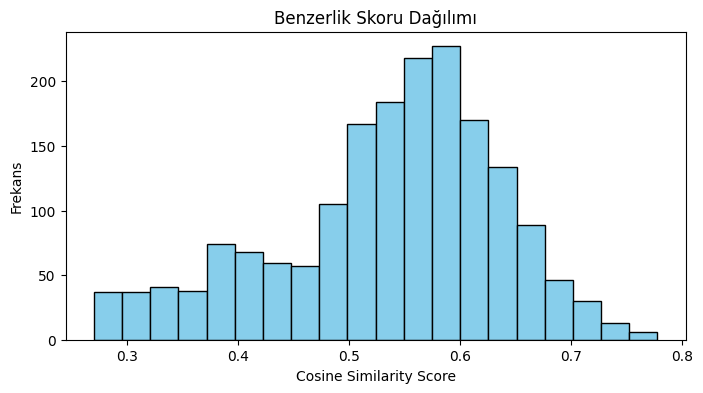

In [ ]:
import matplotlib.pyplot as plt

def plot_score_distribution(queries, k=20):
    all_scores = []
    for ex in queries:
        scores, _ = search_topk(ex["query"], k)
        all_scores.extend(scores)
    plt.figure(figsize=(8,4))
    plt.hist(all_scores, bins=20, color="skyblue", edgecolor="black")
    plt.title("Benzerlik Skoru Dağılımı")
    plt.xlabel("Cosine Similarity Score")
    plt.ylabel("Frekans")
    plt.show()

plot_score_distribution(title_queries)

In [ ]:
import pandas as pd

results_summary = pd.DataFrame([
    {"Bucket": "Title Recall@5", "Value": title_recall},
    {"Bucket": "Adversarial Avoid Rate@5", "Value": adv_avoid_rate},
    {"Bucket": "Adversarial Target Recall@5", "Value": adv_target_recall}
])
print("\n=== SONUÇ ÖZETİ ===")
print(results_summary)


=== SONUÇ ÖZETİ ===
                        Bucket     Value
0               Title Recall@5  0.988889
1     Adversarial Avoid Rate@5  0.333333
2  Adversarial Target Recall@5  0.333333


In [ ]:
import pandas as pd

# AG News: 4 sınıf (0=World, 1=Sports, 2=Business, 3=Sci/Tech)
raw = load_dataset("ag_news")

# Dengeli küçük set: her sınıftan N örnek (örn. 500)
N_PER_CLASS = 500
df_train = pd.DataFrame(raw["train"])
label_names = {0:"World", 1:"Sports", 2:"Business", 3:"Sci/Tech"}

balanced = []
for lab in range(4):
    sub = df_train[df_train["label"]==lab].sample(N_PER_CLASS, random_state=42)
    sub = sub.assign(label_name=label_names[lab])
    balanced.append(sub)
df = pd.concat(balanced, ignore_index=True).reset_index(drop=True)
len(df), df.label.value_counts()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

(2000,
 label
 0    500
 1    500
 2    500
 3    500
 Name: count, dtype: int64)

In [ ]:
df.head()

,text,label,label_name
0,"Explosion Rocks Baghdad Neighborhood BAGHDAD, ...",0,World
1,BBC reporters' log BBC correspondents record e...,0,World
2,Israel welcomes Rice nomination; Palestinians ...,0,World
3,Medical Journal Calls for a New Drug Watchdog ...,0,World
4,Militants Kidnap Relatives of Iraqi Minister-T...,0,World


In [ ]:
import uuid

def build_docs(df):
    docs = []
    for i, row in df.iterrows():
        doc_id = str(uuid.uuid4())
        title, text, label, label_name = row["title"], row["text"], row["label"], row["label_name"]
        combined = f"{title}\n{text}"   # başlık sinyali + içerik
        docs.append({
            "doc_id": doc_id,
            "title": title,
            "body": text,
            "text": combined,
            "topic": label_name,
            "source": f"ag_news/train/{i}"
        })
    return docs

docs = build_docs(df)
len(docs), docs[0]

KeyError: 'title'

In [ ]:
print(df.columns)